# Pricing European Put Options

### Introduction
<br>
Suppose a <a href="http://www.theoptionsguide.com/put-option.aspx">European put option</a> with strike price $K$ and an underlying asset whose spot price at maturity $S_T$ follows a given random distribution.
The corresponding payoff function is defined as:

$$\max\{K - S_T, 0\}$$

In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price before discounting, for the option:

$$\mathbb{E}\left[ \max\{K - S_T, 0\} \right]$$

as well as the corresponding $\Delta$, i.e., the derivative of the option price with respect to the spot price, defined as:

$$
\Delta = -\mathbb{P}\left[S_T \leq K\right]
$$

The approximation of the objective function and a general introduction to option pricing and risk analysis on quantum computers are given in the following papers:

- [Quantum Risk Analysis. Woerner, Egger. 2018.](https://arxiv.org/abs/1806.06893)
- [Option Pricing using Quantum Computers. Stamatopoulos et al. 2019.](https://arxiv.org/abs/1905.02666)

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

### Uncertainty Model

We construct a circuit to load a log-normal random distribution into a quantum state.
The distribution is truncated to a given interval $[\text{low}, \text{high}]$ and discretized using $2^n$ grid points, where $n$ denotes the number of qubits used.
The unitary operator corresponding to the circuit implements the following: 

$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i}\big|i\rangle_{n},$$

where $p_i$ denote the probabilities corresponding to the truncated and discretized distribution and where $i$ is mapped to the right interval using the affine map:

$$ \{0, \ldots, 2^n-1\} \ni i \mapsto \frac{\text{high} - \text{low}}{2^n - 1} * i + \text{low} \in [\text{low}, \text{high}].$$

In [2]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

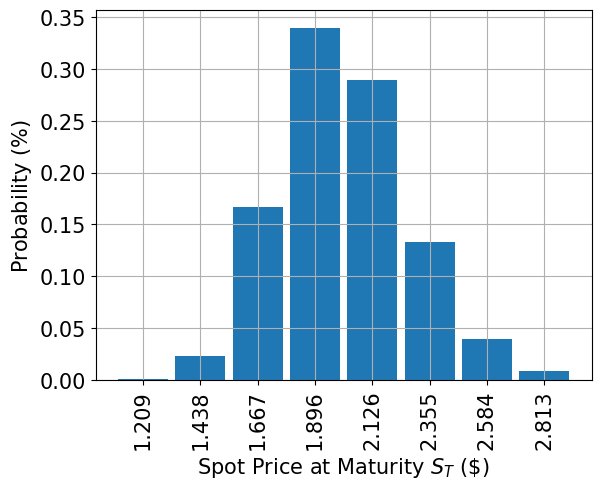

In [3]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

### Payoff Function

The payoff function decreases linearly with an increasing spot price at maturity $S_T$ until it reaches zero for a spot price equal to the strike price $K$, it stays constant to zero for larger spot prices.
The implementation uses a comparator, that flips an ancilla qubit from $\big|0\rangle$ to $\big|1\rangle$ if $S_T \leq K$, and this ancilla is used to control the linear part of the payoff function.

The linear part itself is then approximated as follows.
We exploit the fact that $\sin^2(y + \pi/4) \approx y + 1/2$ for small $|y|$.
Thus, for a given approximation rescaling scaling factor $c_\text{approx} \in [0, 1]$ and $x \in [0, 1]$ we consider
$$ \sin^2( \pi/2 * c_\text{approx} * ( x - 1/2 ) + \pi/4) \approx \pi/2 * c_\text{approx} * ( x - 1/2 ) + 1/2 $$ for small $c_\text{approx}$.

We can easily construct an operator that acts as 
$$\big|x\rangle \big|0\rangle \mapsto \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right),$$
using controlled Y-rotations.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit, which corresponds to
$\sin^2(a*x+b)$.
Together with the approximation above, this allows to approximate the values of interest.
The smaller we choose $c_\text{approx}$, the better the approximation.
However, since we are then estimating a property scaled by $c_\text{approx}$, the number of evaluation qubits $m$ needs to be adjusted accordingly.

For more details on the approximation, we refer to:
[Quantum Risk Analysis. Woerner, Egger. 2018.](https://arxiv.org/abs/1806.06893)

In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2.126

# set the approximation scaling for the payoff function
rescaling_factor = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [-1, 0]
offsets = [strike_price - low, 0]
f_min = 0
f_max = strike_price - low
european_put_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=rescaling_factor,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
european_put = european_put_objective.compose(uncertainty_model, front=True)

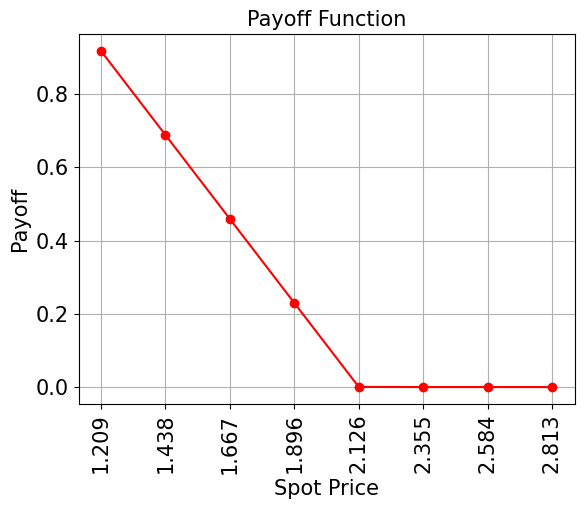

In [5]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, strike_price - x)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = -sum(uncertainty_model.probabilities[x <= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.1709
exact delta value:   	-0.8193


### Evaluate Expected Payoff

In [7]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_put,
    objective_qubits=[num_uncertainty_qubits],
    post_processing=european_put_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)

In [8]:
result = ae.estimate(problem)

In [9]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1709
Estimated value:    	0.1766
Confidence interval:	[0.1716, 0.1816]


### Evaluate Delta

The Delta is a bit simpler to evaluate than the expected payoff.
Similarly to the expected payoff, we use a comparator circuit and an ancilla qubit to identify the cases where $S_T \leq K$.
However, since we are only interested in the (negative) probability of this condition being true, we can directly use this ancilla qubit as the objective qubit in amplitude estimation without any further approximation.

In [10]:
# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 0]
offsets = [1, 0]
f_min = 0
f_max = 1

european_put_delta_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
)

# construct circuit for payoff function
european_put_delta = european_put_delta_objective.compose(uncertainty_model, front=True)

In [11]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_put_delta, objective_qubits=[num_uncertainty_qubits]
)
# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)

In [12]:
result_delta = ae_delta.estimate(problem)

In [13]:
conf_int = -np.array(result_delta.confidence_interval)[::-1]
print("Exact delta:    \t%.4f" % exact_delta)
print("Esimated value: \t%.4f" % -result_delta.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	-0.8193
Esimated value: 	-0.8228
Confidence interval: 	[-0.8291, -0.8166]


In [14]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright